<a href="https://colab.research.google.com/github/Daniel-RivasJimenez/PROYECTOS/blob/main/T.F.M..ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Librerias

In [1]:
!pip install ydata_profiling --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.3/399.3 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.7/679.7 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 1.3 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.3
    Uninstalling scipy-1.16.3:
      Successfully uninstalled scipy-1.16.3


In [3]:
import warnings
warnings.filterwarnings("ignore")

# Sistema de archivos y operaciones básicas
import datetime
from datetime import datetime, timedelta
import time
import threading
import re

# Manipulación de datos y análisis
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup

# Visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

# Análisis y preprocesamiento de datos
from ydata_profiling import ProfileReport
from sklearn.preprocessing import MinMaxScaler

# Modelado predictivo
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

# Modelos avanzados de Machine Learning
import lightgbm as lgb
from lightgbm import LGBMRegressor
import xgboost as xgb
from xgboost import XGBRegressor

# Progreso de bucles
from tqdm import tqdm

# Integración con Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Datos financieros
import yfinance as yf

Mounted at /content/drive


# Definición de Parámetros

In [4]:
start_date_str = "2000-01-04"
end_date_str = "2023-12-31"
start_date = datetime.strptime(start_date_str, "%Y-%m-%d")
end_date = datetime.strptime(end_date_str, "%Y-%m-%d")
next_day = end_date + timedelta(days=3)

test_size = 0.1
test_size_0_2 = 0.2
test_val = 0.5
random_seed = 42
cross_validation = 5
n_jobs = -1
verbose = 2

threshold_non_scaled = 0.5

it_start_date = start_date
it_end_date = end_date

In [5]:
scaler = MinMaxScaler(feature_range=(-1, 1))

Parámetros para la Regresión Lineal

In [6]:
param_grid_lr = {
    'fit_intercept': [True, False],  # Si se debe calcular el intercepto
    'copy_X': [True, False],  # Si se debe copiar X antes de ajustarlo, evitando que se modifiquen los datos originales
    'positive': [True, False],  # Si se deben forzar los coeficientes a ser positivos
    'n_jobs': [None, -1]  # Número de trabajos paralelos para ejecutar (-1 significa utilizar todos los procesadores disponibles)
}

Parámetros para el Random Forest

In [7]:
rf = RandomForestRegressor(bootstrap=True,
                           max_depth=3,
                           min_samples_leaf=2,
                           min_samples_split=2,
                           n_estimators=500,
                           random_state=random_seed)

Parámetros para el LightGMB

In [8]:
num_round = 100

# Definir los parámetros del modelo
params_lgmb = {
    'objective': 'regression',
    'metric': 'mse',
    'num_leaves': 20,
    'learning_rate': 0.05,
    'n_estimators': 50,
    'reg_alpha': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}



# Definir los hiperparámetros que deseas ajustar
param_grid_lgmb = {
    'learning_rate': [0.01, 0.05, 0.2],
    'max_depth': [3, 4, 5],
    'n_estimators': [100, 200, 300]
}

Parámetros para el XGBoost

In [9]:
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.02, 0.15, 0.2],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2]
}

# 1. EDA y normalización


In [10]:
# Descargar datos de Monster Beverage Corporation (MNST)
data = yf.download("MNST", start=start_date, end=end_date, interval="1d")
data

[*********************100%***********************]  1 of 1 completed


Price           Close       High        Low       Open   Volume
Ticker           MNST       MNST       MNST       MNST     MNST
Date                                                           
2000-01-04   0.042969   0.045573   0.042969   0.044922  2438400
2000-01-05   0.042969   0.045573   0.042969   0.044271  1430400
2000-01-06   0.044271   0.044271   0.042969   0.043294  2400000
2000-01-07   0.043294   0.046875   0.042969   0.043294  5251200
2000-01-10   0.043620   0.044271   0.043294   0.043945  6307200
...               ...        ...        ...        ...      ...
2023-12-22  56.009998  56.349998  55.520000  55.650002  3942500
2023-12-26  56.790001  56.919998  55.900002  55.900002  3469100
2023-12-27  57.340000  57.369999  56.720001  56.840000  3606200
2023-12-28  57.419998  57.560001  57.189999  57.509998  3344700
2023-12-29  57.610001  57.779999  57.330002  57.430000  4061400

[6036 rows x 5 columns]

Vamos a calcular la rentabilidad, que será nuestro target.

In [11]:
data['Rentabilidad'] = ((data['Close'] - data['Open']) / data['Open']) * 100

In [12]:
data.head()

Price          Close      High       Low      Open   Volume Rentabilidad
Ticker          MNST      MNST      MNST      MNST     MNST             
Date                                                                    
2000-01-04  0.042969  0.045573  0.042969  0.044922  2438400    -4.347540
2000-01-05  0.042969  0.045573  0.042969  0.044271  1430400    -2.940977
2000-01-06  0.044271  0.044271  0.042969  0.043294  2400000     2.256660
2000-01-07  0.043294  0.046875  0.042969  0.043294  5251200     0.000000
2000-01-10  0.043620  0.044271  0.043294  0.043945  6307200    -0.739556

In [13]:
data.columns

MultiIndex([(       'Close', 'MNST'),
            (        'High', 'MNST'),
            (         'Low', 'MNST'),
            (        'Open', 'MNST'),
            (      'Volume', 'MNST'),
            ('Rentabilidad',     '')],
           names=['Price', 'Ticker'])

In [14]:
data.dtypes

Price         Ticker
Close         MNST      float64
High          MNST      float64
Low           MNST      float64
Open          MNST      float64
Volume        MNST        int64
Rentabilidad            float64
dtype: object

In [15]:
data.shape

(6036, 6)

In [17]:
# EDA: Monster Beverage.

features_report = ['Open', 'High', 'Low', 'Close', 'Volume']
profile = ProfileReport(data[features_report])
profile.to_file("output.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 5/5 [00:00<00:00, 25.70it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [18]:
profile

In [19]:
correlation_matrix = data.corr()
# Mostrar la matriz de correlación
print("Matriz de correlación:")
correlation_matrix

Matriz de correlación:


Price                   Close      High       Low      Open    Volume  \
Ticker                   MNST      MNST      MNST      MNST      MNST   
Price        Ticker                                                     
Close        MNST    1.000000  0.999917  0.999920  0.999828 -0.236581   
High         MNST    0.999917  1.000000  0.999883  0.999919 -0.235444   
Low          MNST    0.999920  0.999883  1.000000  0.999910 -0.237728   
Open         MNST    0.999828  0.999919  0.999910  1.000000 -0.236619   
Volume       MNST   -0.236581 -0.235444 -0.237728 -0.236619  1.000000   
Rentabilidad        -0.029816 -0.034037 -0.034062 -0.038552  0.026180   

Price               Rentabilidad  
Ticker                            
Price        Ticker               
Close        MNST      -0.029816  
High         MNST      -0.034037  
Low          MNST      -0.034062  
Open         MNST      -0.038552  
Volume       MNST       0.026180  
Rentabilidad            1.000000

### 1.2. Graficación de valores

In [20]:
def plot_line_chart(ticker):
    # Descargar datos normalmente para el ticker proporcionado
    data = yf.download(ticker, start=start_date, end=end_date, interval="1d")
    selected_columns = data['Close']

    # Crear el gráfico de líneas
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=selected_columns.index, y=selected_columns, mode='lines', name=f'Close_{ticker}'))

    # Configurar el diseño del gráfico
    fig.update_layout(title=f'Gráfico de Líneas para {ticker}',
                      xaxis_title='Fecha',
                      yaxis_title='Precio',
                      template='plotly_dark')

    # Mostrar el gráfico
    fig.show()

# Llamar a la función para el ticker "MNST" (Monster)
plot_line_chart("MNST")

[*********************100%***********************]  1 of 1 completed


In [21]:
def plot_candlestick_chart(ticker):
    # Descargar datos normalmente para el ticker proporcionado
    data = yf.download(ticker, start=start_date, end=end_date, interval="1d")

    # Crear el gráfico de velas
    fig = go.Figure(data=[go.Candlestick(x=data.index,
                                          open=data['Open'],
                                          high=data['High'],
                                          low=data['Low'],
                                          close=data['Close'])])

    # Configurar el diseño del gráfico
    fig.update_layout(title=f'Gráfico de Velas para {ticker}',
                      xaxis_title='Fecha',
                      yaxis_title='Precio',
                      template='plotly_dark')

    # Mostrar el gráfico
    fig.show()

# Llamar a la función para el ticker "MNST" (Monster)
plot_candlestick_chart("MNST")

[*********************100%***********************]  1 of 1 completed


### 1.3. Normalización y correspondiente EDA

Normalizamos las columnas de volumen y rentabilidad para tener valores en un rango entre [-1,1].
Lo hacemos para ayudar a mejorar la interpretación y el rendimiento de los modelos de aprendizaje automático, especialmente en el contexto de la rentabilidad de acciones, donde se espera una amplia gama de valores positivos y negativos.

In [22]:
# Normalizar la columna "Volume y Rentabilidad"
data['Volume_normalized'] = scaler.fit_transform(data[['Volume']])

data['Rentabilidad_normalized'] = scaler.fit_transform(data[['Rentabilidad']])

In [24]:
# EDA MODELO ESCALADO (PROFILE REPORT CON TODAS LAS COLUMNAS)

features_report = ['Open', 'High', 'Low', 'Close','Volume','Rentabilidad','Volume_normalized','Rentabilidad_normalized']
profile = ProfileReport(data[features_report])
profile.to_file("output.html")

profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 8/8 [00:00<00:00, 21.19it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# 2. Definir Target y dividir en entrenamiento, test y validación



El target será la rentabilidad diaria de cada acción, para ello la hemos calculado anteriormente.

In [25]:
# Seleccionar los datos para el IT
df_it = data.loc[(data.index >= it_start_date) & (data.index <= it_end_date)]

# Dividir el DataFrame en características (X) y la variable objetivo (y)
X = df_it.drop(["Rentabilidad", "Rentabilidad_normalized" ,"Close","Volume"], axis=1)
y = df_it["Rentabilidad_normalized"]

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=test_size, random_state=random_seed)

# Dividir los datos temporales en conjuntos de validación y prueba
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=test_val, random_state=random_seed)

# Imprimir el número de filas en cada conjunto
print("IT DataSet has {} rows".format(len(df_it)))
print("X_train has {} rows".format(len(X_train)))
print("X_val has {} rows".format(len(X_val)))
print("X_test has {} rows".format(len(X_test)))

IT DataSet has 6036 rows
X_train has 5432 rows
X_val has 302 rows
X_test has 302 rows


Observamos si en nuestros df creados tenemos valores nan ya que no es recomendable tenerlos en la regresión lineal ni en el random forest

In [26]:
nan_values = df_it.isna().any().any()

if nan_values:
    count_nan = df_it.isna().sum().sum()  # Suma de todos los valores NaN
    print(f"Tu DataFrame 'data' contiene {count_nan} valores NaN.")
else:
    print("Tu DataFrame 'data' no contiene valores NaN.")

Tu DataFrame 'data' no contiene valores NaN.


# 3. COMPARACION DE MODELOS:

Para nuestro estudio, vamos a realizar una comparacion del MSE entre los modelos de Regresio Lineal, Random Forest y LightGMB, nos quedaremos con el que el error sea menor y nos aporte mayor fiabilidad al estudio.

## 3.1. Regresión Lineal



In [28]:
list(data.columns)

[('Close', 'MNST'),
 ('High', 'MNST'),
 ('Low', 'MNST'),
 ('Open', 'MNST'),
 ('Volume', 'MNST'),
 ('Rentabilidad', ''),
 ('Volume_normalized', ''),
 ('Rentabilidad_normalized', '')]

In [29]:
list(X)

[('High', 'MNST'),
 ('Low', 'MNST'),
 ('Open', 'MNST'),
 ('Volume_normalized', '')]

In [30]:
list(y.head(3))

[-0.3194783971203333, -0.25157760405236174, -0.0006654303755699587]

## 3.1. REGRESION LINEAL

Mean Squared Error: 0.01607009097028498


Text(0, 0.5, 'Frecuencia')

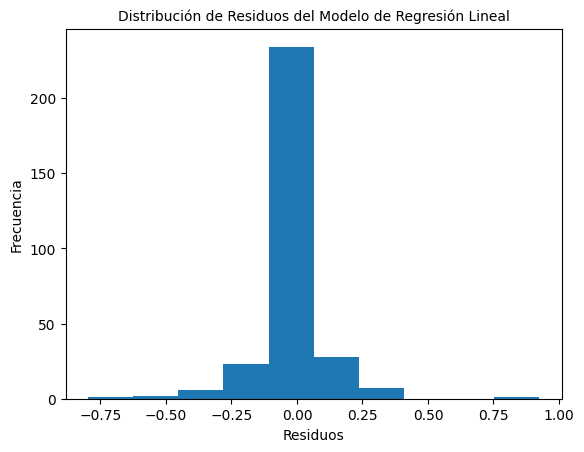

In [31]:
# Crear y entrenar el modelo de regresión lineal
model = LinearRegression()
model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Evaluar el modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
# print(f'R-squared: {r2}') no lo usamos
plt.hist(y_test - y_pred) # vemos que esta centrado en el 0, por lo que podemos aceptarlo

plt.title("Distribución de Residuos del Modelo de Regresión Lineal", fontsize=10)
plt.xlabel("Residuos", fontsize=10)
plt.ylabel("Frecuencia", fontsize=10)

AttributeError: 'DataFrame' object has no attribute 'argsort'

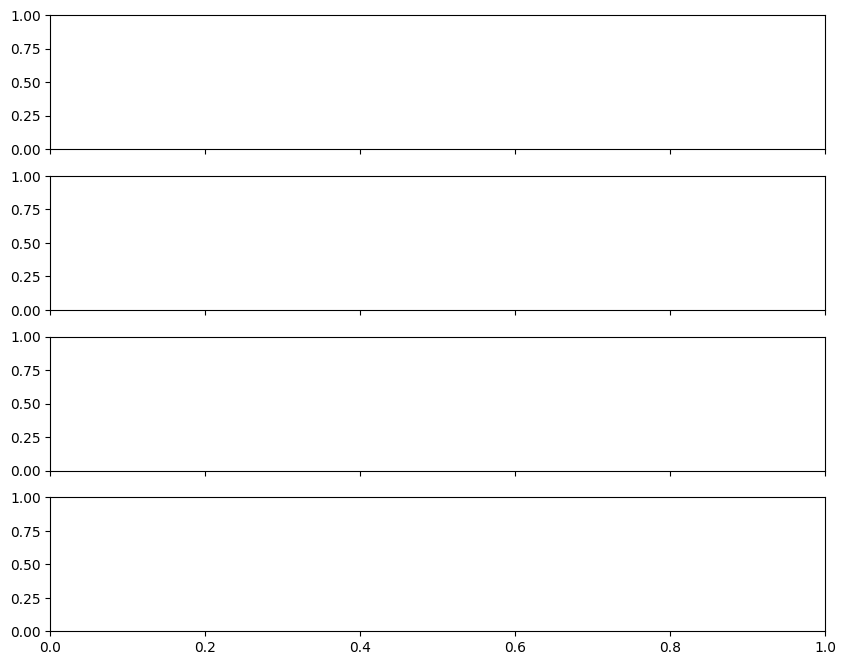

In [33]:
# Seleccionar las características que deseas visualizar
features = ['Open', 'High', 'Low','Volume_normalized']

# Crear una figura y subtramas
fig, axes = plt.subplots(nrows=len(features), ncols=1, figsize=(10, 8), sharex=True)

# Iterar sobre cada característica y crear un gráfico para ella
for i, feature in enumerate(features):
    # Seleccionar la característica y ordenar los valores
    X_feature = X_test[feature]
    sorted_indices = X_feature.argsort()
    X_feature_sorted = X_feature.iloc[sorted_indices]
    y_test_sorted = y_test.iloc[sorted_indices]
    y_pred_sorted = y_pred[sorted_indices]

    # Graficar la regresión lineal y los datos de prueba para la característica actual
    axes[i].scatter(X_feature_sorted, y_test_sorted, color='black', label='Datos de prueba')
    axes[i].plot(X_feature_sorted, y_pred_sorted, color='blue', linewidth=3, label='Regresión Lineal')
    axes[i].set_ylabel('Rentabilidad_normalized')
    axes[i].set_title('Rentabilidad_normalized vs. ' + feature)
    axes[i].legend()

    # Aplicar zoom en el eje Y
    axes[i].set_ylim(-0.3, -0.1)

# Ajustar el espacio entre subtramas
plt.tight_layout()
plt.xlabel('Días')
plt.show()

Ploteamos Independientemente el Volumen

In [ ]:
# Seleccionar la característica 'Volume'
feature = 'Volume_normalized'

# Seleccionar la característica y ordenar los valores
X_feature = X_test[feature]
sorted_indices = X_feature.argsort()
X_feature_sorted = X_feature.iloc[sorted_indices]
y_test_sorted = y_test.iloc[sorted_indices]
y_pred_sorted = y_pred[sorted_indices]

# Visualizar el modelo lineal y los datos de prueba
plt.scatter(X_feature_sorted, y_test_sorted, color='black', label='Datos de prueba')
plt.plot(X_feature_sorted, y_pred_sorted, color='blue', linewidth=3, label='Regresión Lineal')
plt.xlabel(feature)
plt.ylabel('Rentabilidad')
plt.title('Regresión Lineal: Rentabilidad vs. ' + feature)
plt.legend()
plt.show()

Vamos a hacer una mascara para eliminar un outlier, con la condicion de que el volumen sea menor a 0.6

In [ ]:
# Seleccionar la característica 'Volume_normalized'
feature = 'Volume_normalized'

# Aplicar una máscara para eliminar los outliers en el rango de -1 a -0.93
mask = ((X_test[feature] >= -1) & (X_test[feature] < -0.93))
X_feature_masked = X_test[feature][mask]
y_test_masked = y_test[mask]
y_pred_masked = y_pred[mask]

# Visualizar el modelo lineal y los datos de prueba después de aplicar la máscara
plt.scatter(X_feature_masked, y_test_masked, color='black', label='Datos de prueba')
plt.plot(X_feature_masked, y_pred_masked, color='blue', linewidth=3, label='Regresión Lineal')
plt.xlabel(feature)
plt.ylabel

### GRIDSEARCH CV

In [ ]:
# Inicializa GridSearchCV con el modelo y los hiperparámetros definidos
grid_search = GridSearchCV(estimator=model, param_grid=param_grid_lr, scoring='neg_mean_squared_error', cv=cross_validation)

# Realiza el ajuste para encontrar los mejores hiperparámetros
grid_search.fit(X_train, y_train)

# Obtiene los mejores hiperparámetros encontrados
best_params_lr = grid_search.best_params_

In [ ]:
best_params_lr

In [ ]:
# Utiliza los mejores hiperparámetros para inicializar el modelo
model = LinearRegression(**best_params_lr)

# Entrena el modelo con los datos de entrenamiento
model.fit(X_train, y_train)

# Realiza predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Evalúa el modelo
mse_test_RL_GS = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse_test_RL_GS}')
plt.hist(y_test - y_pred)

### Validación Cruzada Regresión Lineal

In [ ]:
# Crear y entrenar el modelo de regresión lineal con validación cruzada
model = LinearRegression()

# Realizar validación cruzada
scores = cross_val_score(model, X, y, cv=cross_validation, scoring='neg_mean_squared_error')

# Calcular el promedio del error cuadrático medio (MSE) negativo
mean_mse_RL_KV = -scores.mean()

# Calcular el promedio del coeficiente de determinación (R-squared)
mean_r2_RL = scores.mean()

print(f'Mean Squared Error: {mean_mse_RL_KV}')
print(f'Mean R-squared: {mean_r2_RL}')

### Valor Residual

In [ ]:
# Calcular los residuos
residuals_test0 = y_test - y_pred

# Imprimir los primeros 10 valores residuales
print("Residuals:")
residuals_test0.head(10)

In [ ]:
# Calcular los residuos
residuals_test0 = y_test - y_pred

# Crear el histograma de los residuos
plt.figure(figsize=(10, 6))
plt.hist(residuals_test0, bins=20, color='skyblue', edgecolor='black')

# Añadir título y etiquetas
plt.title('Histograma de Residuos del Modelo de Regresión Lineal')
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')
plt.show()

## 3.2. Random Forest
Aunque el RF se especializa en problemas de clasificación, nosotros tenemos un problema de regresión, donde también nos puede ser útil.

In [ ]:
# Entrenar el modelo de Random Forest con los parámetros proporcionados
rf.fit(X_train, y_train)

### GRIDSEARCH CV

In [ ]:
# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid_rf,
                           cv=cross_validation, n_jobs=n_jobs, verbose=verbose)

# Ejecutar GridSearchCV en los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Mostrar los mejores parámetros
print("Mejores parámetros encontrados:", grid_search.best_params_)

In [ ]:
# Realizar predicciones en los conjuntos de entrenamiento y prueba
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

# Calcular el error cuadrático medio para cada conjunto
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test_RF_GS = mean_squared_error(y_test, y_test_pred)

# Calcular el coeficiente de determinación (R^2) para cada conjunto
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print("Métricas del conjunto de entrenamiento:")
print("Error cuadrático medio (MSE):", mse_train)
print("Coeficiente de determinación (R^2):", r2_train)

print("\nMétricas del conjunto de prueba:")
print("Error cuadrático medio (MSE):", mse_test_RF_GS)
print("Coeficiente de determinación (R^2):", r2_test)

Aquí vamos a visualizar nuestras métricas vs los valores reales

In [ ]:
# Crear un rango de índices para los puntos de datos
indices = range(len(y_test))

# Graficar las predicciones vs los valores reales en el conjunto de prueba
plt.figure(figsize=(10, 6))
plt.plot(indices, y_test, color='red', label='Valores reales')
plt.plot(indices, y_pred, color='blue', label='Predicciones')
plt.xlabel('Índices de muestra')
plt.ylabel('Valor')
plt.title('Predicciones vs Valores Reales')
plt.legend()
plt.show()

###  Validación cruzada Random Forest

In [ ]:
# Realizar validación cruzada para MSE
cv_scores_mse = cross_val_score(rf, X_train, y_train, cv=cross_validation, scoring='neg_mean_squared_error')

# Convertir los puntajes negativos de MSE a positivos y calcular el promedio
mse_scores = -cv_scores_mse
mean_mse_RF_KV = mse_scores.mean()

# Imprimir el resultado del MSE
print(f'Mean Squared Error (MSE) after 5-fold cross validation: {mean_mse_RF_KV}')

# Realizar validación cruzada para R2
cv_scores_r2 = cross_val_score(rf, X_train, y_train, cv=cross_validation, scoring='r2')

# Calcular el promedio del coeficiente de determinación R2
mean_r2_RF = cv_scores_r2.mean()

# Imprimir el resultado de R2
print(f'Mean R-squared (R2) after 5-fold cross validation: {mean_r2_RF}')

### Valor Residual

In [ ]:
# Calcular los residuos en el conjunto de entrenamiento
# residuals_train = y_train - y_train_pred

# Calcular los residuos en el conjunto de prueba
residuals_test1 = y_test - y_test_pred

# Imprimir los primeros 10 valores residuales del conjunto de prueba
print("Residuals del conjunto de prueba:")
print(residuals_test1[:10])

In [ ]:
# Calcular los residuos en el conjunto de prueba
# residuals_test1 = y_test - y_test_pred

# Crear histograma de los residuos en el conjunto de prueba
plt.figure(figsize=(10, 6))
plt.hist(residuals_test1, bins=20, color='skyblue', edgecolor='black')

# Añadir título y etiquetas
plt.title('Histograma de Residuos (Conjunto de Prueba) del Random Forest')
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')
plt.show()

## 3.3. LightGMB

In [ ]:
# Crear un conjunto de datos LightGBM
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

# Entrenar el modelo LightGBM
bst = lgb.train(params_lgmb, train_data, num_round, valid_sets=[test_data])

# Realizar predicciones en el conjunto de prueba
y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)

# Evaluar el rendimiento del modelo
mse_test_GMB_GS = mean_squared_error(y_test, y_pred)
print("Error cuadrático medio (MSE):", mse_test_GMB_GS)

### Gridsearch CV

In [ ]:
# Crear un modelo LightGBM
lgb_model = lgb.LGBMRegressor()

# Crear un objeto GridSearchCV
grid_search = GridSearchCV(estimator=lgb_model, param_grid=param_grid_lgmb, scoring='neg_mean_squared_error', cv=cross_validation)

# Realizar la búsqueda en la cuadrícula utilizando los datos de entrenamiento
grid_search.fit(X_train, y_train)

In [ ]:
 grid_search.best_params_

### Validación Cruzada LightGMB


In [ ]:
# Crear un conjunto de datos LightGBM para el conjunto de entrenamiento
train_data = lgb.Dataset(X_train, label=y_train)

# Definir los parámetros del modelo. Ya están definidos arriba. Linea 19.
''' params = {
    'objective': 'regression',
    'metric': 'mse',
    'num_leaves': 20,
    'learning_rate': 0.05,
    'n_estimators': 50,
    'reg_alpha': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1  # Desactiva todas las advertencias (warnings)
}
 '''
# Crear el modelo LightGBM
model = lgb.LGBMRegressor(**params_lgmb)

# Realizar la validación cruzada para MSE
cv_scores_mse = cross_val_score(model, X_train, y_train, cv=cross_validation, scoring='neg_mean_squared_error')

# Convertir los puntajes negativos de MSE a positivos y calcular el promedio
mse_scores = -cv_scores_mse
mean_mse_GMB_KV = mse_scores.mean()

# Imprimir el resultado del MSE
print(f'Mean Squared Error (MSE) after 5-fold cross validation: {mean_mse_GMB_KV}')

# Realizar la validación cruzada para R2
cv_scores_r2 = cross_val_score(model, X_train, y_train, cv=cross_validation, scoring='r2')

# Calcular el promedio del coeficiente de determinación R2
mean_r2_GMB = cv_scores_r2.mean()

# Imprimir el resultado de R2
print(f'Mean R-squared (R2) after 5-fold cross validation: {mean_r2_GMB}')

### Valor Residual

In [ ]:
# Calcular los residuos en el conjunto de entrenamiento
# residuals_train = y_train - y_train_pred

# Calcular los residuos en el conjunto de prueba
residuals_test2 = y_test - y_pred

# Imprimir los primeros 10 valores residuales del conjunto de prueba
print("Residuals del conjunto de prueba:")
print(residuals_test2[:10])

In [ ]:
# Calcular los residuos en el conjunto de prueba
residuals_test2 = y_test - y_pred

# Crear histograma de los residuos en el conjunto de prueba
plt.figure(figsize=(10, 6))
plt.hist(residuals_test2, bins=20, color='skyblue', edgecolor='black')

# Añadir título y etiquetas
plt.title('Histograma de Residuos (Conjunto de Prueba) de Light GMB')
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')
plt.show()

## 3.4.XGBOOST

In [ ]:
# Crear el modelo XGBoost
model = xgb.XGBRegressor()

# Entrenar el modelo
model.fit(X_train, y_train)

# Predecir los valores de rentabilidad normalizados en el conjunto de prueba
y_pred = model.predict(X_test)

# Calcular el MSE
mse = mean_squared_error(y_test, y_pred)

print("El Mean Squared Error (MSE) es:", mse)
print(y_pred)

### 3.4.1 grid search

In [ ]:
grid_search = GridSearchCV(estimator=model, param_grid=param_grid_xgb, cv=verbose, n_jobs=n_jobs, scoring='neg_mean_squared_error')

# Ejecutar la búsqueda de cuadrícula en los datos de entrenamiento con una barra de progreso
with tqdm(total=len(param_grid_xgb['n_estimators']) * len(param_grid_xgb['max_depth']) * len(param_grid_xgb['learning_rate']) * len(param_grid_xgb['subsample']) * len(param_grid_xgb['colsample_bytree']) * len(param_grid_xgb['gamma'])) as pbar:
    grid_search.fit(X_train, y_train)
    pbar.update(1)

# Obtener los mejores hiperparámetros encontrados
best_params_xgb = grid_search.best_params_
print("Los mejores hiperparámetros encontrados son:", best_params_xgb)

# Utilizar el modelo con los mejores hiperparámetros para hacer predicciones
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

### 3.4.3. validacion cruzada



In [ ]:
# Crear el modelo XGBoost
model = xgb.XGBRegressor(**best_params_xgb)

# Realizar la validación cruzada
mse_scores = cross_val_score(model, X_train, y_train, cv=cross_validation, scoring='neg_mean_squared_error')

# Convertir los puntajes de MSE negativos a positivos
mse_scores = -mse_scores

# Calcular el MSE promedio y la desviación estándar
mean_mse_XGB_KV = mse_scores.mean()

print("Resultados de validación cruzada:")
print("Mean Squared Error (MSE) promedio:", mean_mse_XGB_KV)

mse_test_XGB_GS = mean_squared_error(y_test, y_pred)
print("El Mean Squared Error (MSE) utilizando los mejores hiperparámetros es:", mse_test_XGB_GS)

'''

# Crear el modelo LightGBM
model = lgb.LGBMRegressor(**params_lgmb)

# Realizar la validación cruzada para MSE
cv_scores_mse = cross_val_score(model, X_train, y_train, cv=cross_validation, scoring='neg_mean_squared_error')

# Convertir los puntajes negativos de MSE a positivos y calcular el promedio
mse_scores = -cv_scores_mse
mean_mse_GMB_KV = mse_scores.mean()

# Imprimir el resultado del MSE
print(f'Mean Squared Error (MSE) after 5-fold cross validation: {mean_mse_GMB_KV}')

# Realizar la validación cruzada para R2
cv_scores_r2 = cross_val_score(model, X_train, y_train, cv=cross_validation, scoring='r2')

# Calcular el promedio del coeficiente de determinación R2
mean_r2_GMB = cv_scores_r2.mean()

# Imprimir el resultado de R2
print(f'Mean R-squared (R2) after 5-fold cross validation: {mean_r2_GMB}') '''

### 3.4.4. valor residual

In [ ]:
# Dividir el DataFrame completo en características (X) y la variable objetivo (y)
# X = df_it.drop(["Rentabilidad","Rentabilidad_normalized","Close","Volume"], axis=1)
# y = df_it["Rentabilidad_normalized"]

# Dividir los datos en conjuntos de entrenamiento y prueba
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_seed)
'''
# Crear y entrenar el modelo XGBoost con los mejores hiperparámetros encontrados
best_model = xgb.XGBRegressor(learning_rate=best_params_xgb['learning_rate'],
                               max_depth=best_params_xgb['max_depth'],
                               n_estimators=best_params_xgb['n_estimators'],
                               subsample=best_params_xgb['subsample'],
                               gamma=best_params_xgb['gamma'],
                               colsample_bytree=best_params_xgb['colsample_bytree'])
best_model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = best_model.predict(X_test)
 '''
# Calcular los residuos
residuals_test3 = y_test - y_pred
print(residuals_test3[:10])

In [ ]:
# Crear histograma de los residuos en el conjunto de prueba (residuals_test3)
plt.figure(figsize=(10, 6))
plt.hist(residuals_test3, bins=20, color='skyblue', edgecolor='black')

# Añadir título y etiquetas
plt.title('Histograma de Residuos (Conjunto de Prueba) de XGBoost')
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')
plt.show()

# 4. RESULTADO DE LA COMPARACIÓN DE LOS MODELOS:

In [34]:
'''
En el LightGMB, el MSE despues de la validacion cruzada (0.004012523386813407) es menor que cuando realizamos el gridsearch (0.005202726655911077), por lo que nos quedariamos
con el de Validación Cruzada.
'''
print(f'MSE RL GRIDSEARCH {mse_test_RL_GS}')
print(f'MSE RL VALIDACION {mean_mse_RL_KV}')
print()
'''
En el LightGMB, el MSE despues de la validacion cruzada (0.004068916719098916) es menor que cuando realizamos el gridsearch (0.005617624942031694), por lo que nos quedariamos
con el de Validación Cruzada.
'''
print(f'MSE RF GRIDSEARCH {mse_test_RF_GS}')
print(f'MSE RF VALIDACION {mean_mse_RF_KV}')
print()
'''
En el LightGMB, el MSE despues de la validacion cruzada (0.0038537084923566667) es menor que cuando realizamos el gridsearch (0.004761497669264618), por lo que nos quedariamos
con el de Validación Cruzada.
'''
print(f'MSE GMB GRIDSEARCH {mse_test_GMB_GS}')
print(f'MSE GMB VALIDACION {mean_mse_GMB_KV}')
print()
'''
En el XGBoost, el MSE despues de la validacion cruzada (0.004844710340393013) es menor que cuando realizamos el gridsearch (0.0050089901096838215), por lo que nos quedariamos
con el de Validación Cruzada.
'''
print(f'MSE XGB GRIDSEARCH {mse_test_XGB_GS}')
print(f'MSE XGB VALIDACION {mean_mse_XGB_KV}')
print()

NameError: name 'mse_test_RL_GS' is not defined

In [ ]:
print(f'MSE RL GRIDSEARCH {mse_test_RL_GS}')
print()
print(f'MSE RF GRIDSEARCH {mse_test_RF_GS}')
print()
print(f'MSE GMB GRIDSEARCH {mse_test_GMB_GS}')
print()
print(f'MSE XGB GRIDSEARCH {mse_test_XGB_GS}')
print()

Nos quedaríamos con el modelo de LightGMB despues de realizar la validación cruzada, es el que menor MSE nos proporciona.


## PLOTS

Debemos realizar plots de los mejores resultados de cada modelo que son los de validación cruzada:
- mean_mse_RL_KV
- mean_mse_RF_KV
- mean_mse_GMB_KV
- mean_mse_XGB_KV

Al ser el error, tenemos que quedarnos con el que menor cantidad dé, esto significa que nos quedaremos con la barra más pequeña

Habría que añadir otro resultado, el cual sería el resultado del modelo nuevo que nos indicaría hacer Roberto

Para aumentar la diferencia vertical en el eje y y resaltar las disparidades entre los valores, aplicamos una transformación logarítmica al eje y.


In [ ]:
# Valores de las variables
means = [mse_test_RF_GS, mse_test_RL_GS, mse_test_GMB_GS, mse_test_XGB_GS]

labels = ['Random Forest', 'Regresión Lineal', 'LightGBM', 'XGBoost']

# Elevar al cuadrado los valores para amplificar las diferencias
means_squared = [val ** 2 for val in means]

# Crear el diagrama de barras con los valores al cuadrado
plt.figure(figsize=(10, 6))
plt.bar(labels, means_squared, color=['red', 'yellow', 'blue', 'green'])
plt.title('Comparación de MSE promedio entre modelos (Squared)')
plt.xlabel('Modelos')
plt.ylabel('MSE promedio (Squared)')
plt.show()

Ploteo del Valor Residual de los 3 modelos

In [ ]:
plt.figure(figsize=(12, 8))

# Plotear los residuos para cada conjunto de prueba con colores transparentes, sin relleno y con grosor de línea aumentado
plt.hist(residuals_test0, bins=20, color='red', label='Regresión Lineal', alpha=0.3, histtype='step', linewidth=3)
plt.hist(residuals_test1, bins=20, color='yellow', label='Random Forest', alpha=0.3, histtype='step', linewidth=3)
plt.hist(residuals_test2, bins=20, color='blue', label='LightGBM', alpha=0.3, histtype='step', linewidth=3)
plt.hist(residuals_test3, bins=20, color='green', label='XGBoost', alpha=0.3, histtype='step', linewidth=3)

plt.title('Residuos del conjunto de prueba a lo largo del tiempo')
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

# 5. MODELO FINAL (INCLUYE BINARIZACION)


## Descarga de Datos

In [35]:
df = data.copy()

In [37]:
columnas_binarizar = ['Open', 'High', 'Low', 'Close','Rentabilidad','Volume_normalized','Rentabilidad_normalized','Volume']
for columna in columnas_binarizar:
    df[columna] = (df[columna].shift(1) < df[columna]).astype(int)

In [38]:
df.head()

Price      Close High  Low Open Volume Rentabilidad Volume_normalized  \
Ticker      MNST MNST MNST MNST   MNST                                  
Date                                                                    
2000-01-04     0    0    0    0      0            0                 0   
2000-01-05     0    0    0    0      0            1                 0   
2000-01-06     1    0    0    0      1            0                 1   
2000-01-07     0    1    0    0      1            0                 0   
2000-01-10     1    0    1    1      1            0                 0   

Price      Rentabilidad_normalized  
Ticker                              
Date                                
2000-01-04                       0  
2000-01-05                       1  
2000-01-06                       0  
2000-01-07                       0  
2000-01-10                       0

In [39]:
# Esta vale para chequear si está o no bien.
data.head()

Price          Close      High       Low      Open   Volume Rentabilidad  \
Ticker          MNST      MNST      MNST      MNST     MNST                
Date                                                                       
2000-01-04  0.042969  0.045573  0.042969  0.044922  2438400    -4.347540   
2000-01-05  0.042969  0.045573  0.042969  0.044271  1430400    -2.940977   
2000-01-06  0.044271  0.044271  0.042969  0.043294  2400000     2.256660   
2000-01-07  0.043294  0.046875  0.042969  0.043294  5251200     0.000000   
2000-01-10  0.043620  0.044271  0.043294  0.043945  6307200    -0.739556   

Price      Volume_normalized Rentabilidad_normalized  
Ticker                                                
Date                                                  
2000-01-04         -0.991002               -0.319478  
2000-01-05         -0.994722               -0.251578  
2000-01-06         -0.991144               -0.000665  
2000-01-07         -0.980622               -0.109604  
2000-01-10         -0.976725               -0.145306

In [40]:
''' # Seleccionar el rango de fechas para el IT
it_start_date = start_date
it_end_date = end  # Ajusta las fechas según tus necesidades
 '''
# Seleccionar los datos para el IT
df_it_normalizado = data.loc[(data.index >= it_start_date) & (data.index <= it_end_date)]

# Dividir el DataFrame en características (X) y la variable objetivo (y)
X = df_it_normalizado.drop(["Rentabilidad","Rentabilidad_normalized","Close","Volume"], axis=1)
y = df_it_normalizado["Rentabilidad_normalized"]

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=test_size_0_2, random_state=random_seed)

# Dividir los datos temporales en conjuntos de validación y prueba
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=test_val, random_state=random_seed)

# Imprimir el número de filas en cada conjunto
print("IT DataSet has {} rows".format(len(df_it)))
print("X_train has {} rows".format(len(X_train)))
print("X_val has {} rows".format(len(X_val)))
print("X_test has {} rows".format(len(X_test)))

IT DataSet has 6036 rows
X_train has 4828 rows
X_val has 604 rows
X_test has 604 rows


## En esta celda siguiente, probamos el test

In [ ]:
# Supongamos que ya tienes los conjuntos X_train, X_val, X_test, y_train, y_val, y_test
# Definir los hiperparámetros que deseas ajustar
# Crear el modelo XGBoost
model = xgb.XGBRegressor()

# Inicializar la búsqueda de cuadrícula
grid_search = GridSearchCV(estimator=model, param_grid=param_grid_xgb, cv=cross_validation, n_jobs= n_jobs, scoring='neg_mean_squared_error')

# Ejecutar la búsqueda de cuadrícula en los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Obtener los mejores hiperparámetros encontrados
best_params = grid_search.best_params_
print("Los mejores hiperparámetros encontrados son:", best_params)

# Utilizar el modelo con los mejores hiperparámetros para hacer predicciones
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calcular el MSE utilizando el mejor modelo
mse_test_XGB_GS = mean_squared_error(y_test, y_pred)
print("El Mean Squared Error (MSE) utilizando los mejores hiperparámetros es:", mse_test_XGB_GS)

best_model = grid_search.best_estimator_
next_day_prediction = best_model.predict(X_test)

# Hacer la predicción para el siguiente día
print("La predicción para el siguiente día es:", next_day_prediction[0])

# Desnormalizar la predicción
scaler = MinMaxScaler(feature_range=(-1, 1))
# Ajustar el escalador a los valores originales de y_train (esto debería haberse hecho previamente)
scaler.fit(y_train.values.reshape(-1, 1))

# Desnormalizar la predicción
next_day_prediction_descaled = scaler.inverse_transform(next_day_prediction.reshape(-1, 1))[0][0]
print("La predicción desnormalizada para el siguiente día es:", next_day_prediction_descaled)

## Aqui vamos a probar la validación, convirtiendo el test en datos de entrenamiento también

In [ ]:
# Supongamos que ya tienes los conjuntos X_train, X_val, X_test, y_train, y_val, y_test
# Concatenar X_train y X_test para usar todo el conjunto de entrenamiento
X_full_train = pd.concat([X_train, X_test])
y_full_train = pd.concat([y_train, y_test])

# Crear el modelo XGBoost
model = xgb.XGBRegressor()

# Inicializar la búsqueda de cuadrícula
grid_search = GridSearchCV(estimator=model, param_grid=param_grid_xgb, cv=cross_validation, n_jobs=n_jobs, scoring='neg_mean_squared_error')

# Ejecutar la búsqueda de cuadrícula en los datos de entrenamiento completo
grid_search.fit(X_full_train, y_full_train)

# Obtener los mejores hiperparámetros encontrados
best_params = grid_search.best_params_
print("Los mejores hiperparámetros encontrados son:", best_params)

# Utilizar el modelo con los mejores hiperparámetros para hacer predicciones en el conjunto de validación
best_model = grid_search.best_estimator_
y_val_pred = best_model.predict(X_val)

# Calcular el MSE utilizando el mejor modelo en el conjunto de validación
mse_val_XGB_GS = mean_squared_error(y_val, y_val_pred)
print("El Mean Squared Error (MSE) en el conjunto de validación es:", mse_val_XGB_GS)

best_model = grid_search.best_estimator_
next_day_val_prediction = best_model.predict(X_val)
print("La predicción normalizada para el siguiente día en el conjunto de validación es:", next_day_val_prediction[0])

# Desnormalizar la predicción
# Ajustar el escalador a los valores originales de y_full_train (esto debería haberse hecho previamente)
scaler = MinMaxScaler(feature_range=(-1, 1))
y_full_train_reshaped = y_full_train.values.reshape(-1, 1)  # Asegúrate de que los datos están en el formato correcto
scaler.fit(y_full_train_reshaped)

# Desnormalizar la predicción
next_day_val_prediction_reshaped = next_day_val_prediction.reshape(-1, 1)
next_day_val_prediction_descaled = scaler.inverse_transform(next_day_val_prediction_reshaped)[0][0]
print("La predicción desnormalizada para el siguiente día en el conjunto de validación es:", next_day_val_prediction_descaled)

## División Binarizado

In [ ]:
# Seleccionar los datos para el IT
df_it_binarizado = df.loc[(df.index >= it_start_date) & (df.index <= it_end_date)]

# Dividir el DataFrame en características (X) y la variable objetivo (y)
X = df_it_binarizado.drop(["Rentabilidad", "Rentabilidad_normalized", "Close", "Volume"], axis=1)
y = df_it_binarizado["Rentabilidad_normalized"]

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=test_size_0_2, random_state=random_seed)

# Dividir los datos temporales en conjuntos de validación y prueba
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=test_val, random_state=random_seed)

# Imprimir el número de filas en cada conjunto
print("IT DataSet has {} rows".format(len(df_it)))
print("X_train has {} rows".format(len(X_train)))
print("X_val has {} rows".format(len(X_val)))
print("X_test has {} rows".format(len(X_test)))

## Aqui vamos a probar el test del Binarizado

In [ ]:
# Supongamos que ya tienes los conjuntos X_train, X_val, X_test, y_train, y_val, y_test
# Definir los hiperparámetros que deseas ajustar

# Crear el modelo XGBoost
model = xgb.XGBRegressor()

# Inicializar la búsqueda de cuadrícula
grid_search = GridSearchCV(estimator=model, param_grid=param_grid_xgb, cv=cross_validation, n_jobs=n_jobs, scoring='neg_mean_squared_error')

# Ejecutar la búsqueda de cuadrícula en los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Obtener los mejores hiperparámetros encontrados
best_params = grid_search.best_params_
print("Los mejores hiperparámetros encontrados son:", best_params)

# Utilizar el modelo con los mejores hiperparámetros para hacer predicciones
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calcular el MSE utilizando el mejor modelo
mse_test_XGB_GS = mean_squared_error(y_test, y_pred)
print("El Mean Squared Error (MSE) utilizando los mejores hiperparámetros es:", mse_test_XGB_GS)

best_model = grid_search.best_estimator_
next_day_prediction = best_model.predict(X_test)
print("La predicción para el siguiente día es:", next_day_prediction[0])

In [ ]:
''' # Suponiendo que ya tienes las predicciones (y_pred) y los valores reales (y_test)
# Calcular el AUC y la curva de ROC
roc_auc = roc_auc_score(y_test, y_pred)
print(f'AUC: {roc_auc:.2f}')

# Calcular la curva de ROC
fpr, tpr, _ = roc_curve(y_test, y_pred)

# Graficar la curva de ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show() '''

In [ ]:
# Convertir las predicciones continuas en clases binarias
y_pred_binary = np.where(y_pred > threshold_non_scaled, 1, 0)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_binary)

print("Matriz de Confusión:")
print(conf_matrix)

# Calcular verdaderos positivos, verdaderos negativos, falsos positivos y falsos negativos
true_positives = conf_matrix[1, 1]
true_negatives = conf_matrix[0, 0]
false_positives = conf_matrix[0, 1]
false_negatives = conf_matrix[1, 0]
print('\n')
# Imprimir los resultados
print("Verdaderos Positivos:", true_positives)
print("Verdaderos Negativos:", true_negatives)
print("Falsos Positivos:", false_positives)
print("Falsos Negativos:", false_negatives)
print('\n')
# Calcular el accuracy
accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives)
print("Accuracy:", accuracy)
accuracy_percentage = accuracy * 100
print("Accuracy (%):", f"{accuracy_percentage:.2f}")
# Calcular la precisión
precision = true_positives / (true_positives + false_positives)
print("Precision:", precision)
precision_percentage = precision * 100
print("Precision (%):", f"{precision_percentage:.2f}")
# Calcular el recall (sensibilidad)
recall = true_positives / (true_positives + false_negatives)
print("Recall (Sensibilidad):", recall)
recall_percentage = recall * 100
print("Recall (Sensibilidad) (%):", f"{recall_percentage:.2f}")
# Calcular la especificidad
specificity = true_negatives / (true_negatives + false_positives)
print("Specificity:", specificity)
specificity_percentage = specificity * 100
print("Specificity (%):", f"{specificity_percentage:.2f}")

## Aqui probamos la validación del Binarizado, convirtiendo los datos de test en datos de entrenamiento también

In [ ]:
# Supongamos que ya tienes los conjuntos X_train, X_val, X_test, y_train, y_val, y_test
# Concatenar X_train y X_test para usar todo el conjunto de entrenamiento
X_full_train = pd.concat([X_train, X_test])
y_full_train = pd.concat([y_train, y_test])

# Crear el modelo XGBoost
model = xgb.XGBRegressor()

# Inicializar la búsqueda de cuadrícula
grid_search = GridSearchCV(estimator=model, param_grid=param_grid_xgb, cv=cross_validation, n_jobs=n_jobs, scoring='neg_mean_squared_error')

# Ejecutar la búsqueda de cuadrícula en los datos de entrenamiento completo
grid_search.fit(X_full_train, y_full_train)

# Obtener los mejores hiperparámetros encontrados
best_params = grid_search.best_params_
print("Los mejores hiperparámetros encontrados son:", best_params)

# Utilizar el modelo con los mejores hiperparámetros para hacer predicciones en el conjunto de validación
best_model = grid_search.best_estimator_
y_val_pred = best_model.predict(X_val)

# Calcular el MSE utilizando el mejor modelo en el conjunto de validación
mse_val_XGB_GS = mean_squared_error(y_val, y_val_pred)
print("El Mean Squared Error (MSE) en el conjunto de validación es:", mse_val_XGB_GS)

best_model = grid_search.best_estimator_
next_day_val_prediction = best_model.predict(X_val)

print("La predicción normalizada para el siguiente día en el conjunto de validación es:", next_day_val_prediction[0])

In [ ]:
# Supongamos que ya tienes las predicciones (y_val_pred) y las etiquetas verdaderas (y_val)
# Calcular el AUC
roc_auc = roc_auc_score(y_val, y_val_pred)
print(f'AUC: {roc_auc:.2f}')

# Calcular la curva de ROC
fpr, tpr, _ = roc_curve(y_val, y_val_pred)

# Graficar la curva de ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Definir el umbral para convertir las predicciones continuas en clases binarias
threshold_non_scaled = 0.5  # Ajusta este valor según sea necesario

# Convertir las predicciones continuas en clases binarias
y_val_pred_binary = np.where(y_val_pred > threshold_non_scaled, 1, 0)

# Calcular la matriz de confusión
conf_matrix_val = confusion_matrix(y_val, y_val_pred_binary)

# Crear el gráfico de la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_val, annot=True, fmt='d', cmap='Blues', cbar=True,
            annot_kws={"size": 16}, linewidths=1.5, linecolor='White')
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Matriz de Confusión en el conjunto de validación', fontsize=16)
plt.show()

# Calcular e imprimir las métricas
true_positives_val = conf_matrix_val[1, 1]
true_negatives_val = conf_matrix_val[0, 0]
false_positives_val = conf_matrix_val[0, 1]
false_negatives_val = conf_matrix_val[1, 0]

accuracy_val = (true_positives_val + true_negatives_val) / (true_positives_val + true_negatives_val + false_positives_val + false_negatives_val)
precision_val = true_positives_val / (true_positives_val + false_positives_val)
recall_val = true_positives_val / (true_positives_val + false_negatives_val)
specificity_val = true_negatives_val / (true_negatives_val + false_positives_val)

print(f"Accuracy: {accuracy_val:.2f}")
print(f"Precision: {precision_val:.2f}")
print(f"Recall (Sensibilidad): {recall_val:.2f}")
print(f"Specificity: {specificity_val:.2f}")


In [ ]:
# Convertir las predicciones continuas en clases binarias
y_val_pred_binary = np.where(y_val_pred > threshold_non_scaled, 1, 0)

# Calcular la matriz de confusión
conf_matrix_val = confusion_matrix(y_val, y_val_pred_binary)

print("Matriz de Confusión en el conjunto de validación:")
print(conf_matrix_val)
print('\n')

# Calcular verdaderos positivos, verdaderos negativos, falsos positivos y falsos negativos
true_positives_val = conf_matrix_val[1, 1]
true_negatives_val = conf_matrix_val[0, 0]
false_positives_val = conf_matrix_val[0, 1]
false_negatives_val = conf_matrix_val[1, 0]

# Imprimir los resultados
print("Verdaderos Positivos en el conjunto de validación:", true_positives_val)
print("Verdaderos Negativos en el conjunto de validación:", true_negatives_val)
print("Falsos Positivos en el conjunto de validación:", false_positives_val)
print("Falsos Negativos en el conjunto de validación:", false_negatives_val)
print('\n')

# Calcular el accuracy en porcentaje
accuracy_val = (true_positives_val + true_negatives_val) / (true_positives_val + true_negatives_val + false_positives_val + false_negatives_val)
accuracy_val_percentage = accuracy_val * 100
print("Accuracy:", accuracy_val)
print("Accuracy(%):", f"{accuracy_val_percentage:.2f}")

# Calcular la precisión en porcentaje
precision_val = true_positives_val / (true_positives_val + false_positives_val)
precision_val_percentage = precision_val * 100
print("Precision:", precision_val)
print("Precision(%):", f"{precision_val_percentage:.2f}")

# Calcular el recall (sensibilidad) en porcentaje
recall_val = true_positives_val / (true_positives_val + false_negatives_val)
recall_val_percentage = recall_val * 100
print("Recall (Sensibilidad):", recall_val)
print("Recall (Sensibilidad)(%):", f"{recall_val_percentage:.2f}")

# Calcular la especificidad en porcentaje
specificity_val = true_negatives_val / (true_negatives_val + false_positives_val)
specificity_val_percentage = specificity_val * 100
print("Specificity:", specificity_val)
print("Specificity(%):", f"{specificity_val_percentage:.2f}")

In [ ]:
''' import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Convertir las predicciones continuas en clases binarias
y_val_pred_binary = np.where(y_val_pred > threshold_non_scaled, 1, 0)

# Calcular la matriz de confusión
conf_matrix_val = confusion_matrix(y_val, y_val_pred_binary)

print("Matriz de Confusión en el conjunto de validación:")
print(conf_matrix_val)
print('\n')

# Calcular verdaderos positivos, verdaderos negativos, falsos positivos y falsos negativos
true_positives_val = conf_matrix_val[1, 1]
true_negatives_val = conf_matrix_val[0, 0]
false_positives_val = conf_matrix_val[0, 1]
false_negatives_val = conf_matrix_val[1, 0]

# Imprimir los resultados
print("Verdaderos Positivos en el conjunto de validación:", true_positives_val)
print("Verdaderos Negativos en el conjunto de validación:", true_negatives_val)
print("Falsos Positivos en el conjunto de validación:", false_positives_val)
print("Falsos Negativos en el conjunto de validación:", false_negatives_val)
print('\n')

# Calcular el accuracy en porcentaje
accuracy_val = (true_positives_val + true_negatives_val) / (true_positives_val + true_negatives_val + false_positives_val + false_negatives_val)
accuracy_val_percentage = accuracy_val * 100
print("Accuracy:", accuracy_val)
print("Accuracy(%):", f"{accuracy_val_percentage:.2f}")

# Calcular la precisión en porcentaje
precision_val = true_positives_val / (true_positives_val + false_positives_val)
precision_val_percentage = precision_val * 100
print("Precision:", precision_val)
print("Precision(%):", f"{precision_val_percentage:.2f}")

# Calcular el recall (sensibilidad) en porcentaje
recall_val = true_positives_val / (true_positives_val + false_negatives_val)
recall_val_percentage = recall_val * 100
print("Recall (Sensibilidad):", recall_val)
print("Recall (Sensibilidad)(%):", f"{recall_val_percentage:.2f}")

# Calcular la especificidad en porcentaje
specificity_val = true_negatives_val / (true_negatives_val + false_positives_val)
specificity_val_percentage = specificity_val * 100
print("Specificity:", specificity_val)
print("Specificity(%):", f"{specificity_val_percentage:.2f}")

# Crear el gráfico de la matriz de confusión
fig, ax = plt.subplots(figsize=(8, 6))

# Mostrar la matriz de confusión con los colores personalizados
ax.matshow(conf_matrix_val, cmap=plt.cm.Blues)

# Asignar colores personalizados a las celdas
for i in range(2):
    for j in range(2):
        color = 'green' if (i == j) else 'blue'
        ax.text(j, i, format(conf_matrix_val[i, j], 'd'),
                ha="center", va="center",
                color="white" if conf_matrix_val[i, j] > conf_matrix_val.max() / 2 else "black",
                bbox=dict(facecolor=color, edgecolor='none'))

ax.set_xticks(np.arange(2))
ax.set_yticks(np.arange(2))
ax.set_xticklabels(['Negativo', 'Positivo'])
ax.set_yticklabels(['Negativo', 'Positivo'])
ax.set_xlabel('Predicción')
ax.set_ylabel('Actual')
ax.set_title('Matriz de Confusión en el Conjunto de Validación')

plt.show()
 '''

# 6. ESCALADO


## Descarga de Tickers. Filtrado (2). Rentabilidad. Descarga de datos

In [ ]:
def get_sp500_listing_dates():
    url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "html.parser")

    table = soup.find("table", {"class": "wikitable sortable"})
    rows = table.find_all("tr")[1:]  # Exclusión de encabezados

    sp500_listing_dates = {}

    for row in rows:
        data = row.find_all("td")
        symbol = data[0].text.strip()
        listing_date = data[5].text.strip()
        sp500_listing_dates[symbol] = listing_date
    return sp500_listing_dates

sp500_listing_dates = get_sp500_listing_dates()

df_list_of_tickers = pd.DataFrame(sp500_listing_dates.items(), columns=['Empresa', 'Listado_SP500'])
df_list_of_tickers.head()

In [ ]:
df_sorted = df_list_of_tickers.sort_values(by='Listado_SP500', ascending=True)
df_sorted['Listado_SP500'] = pd.to_datetime(df_sorted['Listado_SP500'])
df_sorted['Year'] = df_sorted['Listado_SP500'].dt.year
df_sorted.head()

In [ ]:
# Filtrar el DataFrame para incluir solo los listados antes a 2001
df_filtered = df_sorted[df_sorted['Year'] < 2000]
df_filtered.tail()

In [ ]:
df_filtered.shape

In [ ]:
contains_dot = df_sorted["Empresa"].str.contains(".", regex=False)
rows_with_dot = df_sorted[contains_dot]

if len(rows_with_dot) > 0:
    print("Sí, hay filas que contienen un '.' en la columna 'Empresa':")
    print(rows_with_dot)
else:
    print("No hay filas que contengan un '.' en la columna 'Empresa'.")

'''
En las empresas del S&P 500, las siglas con un ".B" (o ".A") indican diferentes clases de acciones para la misma empresa. Las compañías pueden emitir más de una clase de acciones con diferentes derechos de voto, dividendos u otros atributos.
'''

In [ ]:
# Definir la expresión regular para buscar dos o más caracteres en la misma secuencia
pattern = r'(\w)\1{1,}'

# Aplicar la expresión regular a la columna "Empresa"
contains_sequence = df_filtered["Empresa"].str.contains(pattern, regex=True)

# Filtrar las filas que contienen la secuencia
rows_with_sequence = df_filtered[contains_sequence]

if len(rows_with_sequence) > 0:
    print("Sí, hay filas que contienen dos o más caracteres en la misma secuencia en la columna 'Empresa':")
    print(rows_with_sequence)
else:
    print("No hay filas que contengan dos o más caracteres en la misma secuencia en la columna 'Empresa'.")

In [ ]:
tickers = df_filtered['Empresa'].tolist()

# Descargar datos del S&P 500
sp500_data = yf.download(tickers, start=start_date, end=end_date)

# Asegurarse de que el DataFrame no esté vacío
if not sp500_data.empty:
    # Crear un diccionario para almacenar los resultados
    results = {
        'Ticker': [],
        'Rentabilidad Anualizada': [],
        'Rentabilidad Total': []
    }

    # Calcular el retorno diario, acumulado y anualizado para cada ticker
    for ticker in tickers:
        # Calcular el retorno diario
        sp500_data['Daily_Return'] = sp500_data['Adj Close'][ticker].pct_change()

        # Calcular el retorno acumulado
        sp500_data['Cumulative_Return'] = (1 + sp500_data['Daily_Return']).cumprod()

        # Calcular el retorno anualizado
        total_days = sp500_data.shape[0]
        total_years = total_days / 252  # 252 días hábiles en un año
        annualized_return = (sp500_data['Cumulative_Return'].iloc[-1])**(1/total_years) - 1

        # Agregar los resultados al diccionario
        results['Ticker'].append(ticker)
        results['Rentabilidad Anualizada'].append(annualized_return)
        results['Rentabilidad Total'].append(sp500_data['Cumulative_Return'].iloc[-1])

    # Convertir el diccionario en un DataFrame
    result_df = pd.DataFrame(results)

    # Mostrar el DataFrame resultado
    result_df
else:
    print("El DataFrame de datos del S&P 500 está vacío.")

result_df.head()

In [ ]:
# Descargar datos del S&P 500 desde el 1 de enero de 2000 hasta el 31 de diciembre de 2023
sp500_data = yf.download('^GSPC', start=start_date, end=end_date)

# Calcular el retorno diario
sp500_data['Daily_Return'] = sp500_data['Adj Close'].pct_change()

# Calcular el retorno acumulado
sp500_data['Cumulative_Return'] = (1 + sp500_data['Daily_Return']).cumprod()

# Calcular el retorno anualizado
total_years = len(sp500_data) / 252  # 252 días hábiles en un año
annualized_return = (sp500_data['Cumulative_Return'].iloc[-1])**(1/total_years) - 1

# Crear un DataFrame con la rentabilidad anualizada y la rentabilidad total
result_df_SP500 = pd.DataFrame({
    'Ticker': 'SP_500',
    'Rentabilidad Anualizada': [annualized_return],
    'Rentabilidad Total': [sp500_data['Cumulative_Return'].iloc[-1]]
})

result_df_SP500.head()

In [ ]:
concatenated_df = pd.concat([result_df, result_df_SP500], ignore_index=True)
concatenated_df_sorted = concatenated_df.sort_values(by='Rentabilidad Total', ascending=False)
concatenated_df_sorted = concatenated_df_sorted.drop(concatenated_df_sorted[concatenated_df_sorted['Ticker'] == 'BF.B'].index)
concatenated_df_sorted.head()

In [ ]:
# Número determinado
valor_limite = result_df_SP500["Rentabilidad Anualizada"].values[0]

# Crear una máscara booleana para las filas que cumplen la condición
mask = concatenated_df_sorted['Rentabilidad Anualizada'] > valor_limite

# Filtrar el DataFrame
concatenated_df_sorted_filtrado = concatenated_df_sorted[mask]
concatenated_df_sorted_filtrado.head()

In [ ]:
df_maestro = concatenated_df_sorted_filtrado
df_maestro.head()

In [ ]:
# Definir el nombre que quieres buscar
nombre_a_buscar = 'AZO'

# Filtrar el DataFrame para encontrar el nombre específico
resultado = df_maestro[df_maestro['Ticker'] == nombre_a_buscar]
resultado

In [ ]:
# Supongamos que df_maestro ya está definido y tiene una columna llamada 'TICKER'
tickers = df_maestro['Ticker'].tolist()

# Diccionario para almacenar los dataframes de cada ticker
cotizaciones_dict = {}

for ticker in tickers:
    cotizaciones_dict[ticker] = yf.download(ticker, start=start_date, end=end_date)

# Puedes unir todos los dataframes en uno solo si lo deseas
cotizaciones_df = pd.concat(cotizaciones_dict, axis=1)
cotizaciones_df.head()

## Normalización de valores

In [ ]:
# Asegurar que las columnas tengan un MultiIndex
if not isinstance(cotizaciones_df.columns, pd.MultiIndex):
    cotizaciones_df.columns = pd.MultiIndex.from_tuples(cotizaciones_df.columns, names=['Ticker', 'Attribute'])

# Extraer el primer nivel de las columnas que corresponde a los tickers
tickers = cotizaciones_df.columns.get_level_values(0).unique().tolist()

# Crear la columna Rentabilidad para todas las empresas
for ticker in tickers:
    open_prices = cotizaciones_df[(ticker, 'Open')]
    close_prices = cotizaciones_df[(ticker, 'Close')]
    rentabilidad = ((close_prices - open_prices) / open_prices) * 100
    cotizaciones_df[(ticker, 'Rentabilidad')] = rentabilidad

# Normalizar las columnas Volume y Rentabilidad
scaler = MinMaxScaler(feature_range=(-1, 1))

for ticker in tickers:
    # Normalizar la columna Volume
    volume = cotizaciones_df[(ticker, 'Volume')].values.reshape(-1, 1)
    cotizaciones_df[(ticker, 'Volume_normalized')] = scaler.fit_transform(volume)

    # Normalizar la columna Rentabilidad
    rentabilidad = cotizaciones_df[(ticker, 'Rentabilidad')].values.reshape(-1, 1)
    cotizaciones_df[(ticker, 'Rentabilidad_normalized')] = scaler.fit_transform(rentabilidad)

# Ordenar las columnas para que Rentabilidad y las columnas normalizadas estén al final de cada subcolumna
new_columns = []
for ticker in tickers:
    sub_columns = cotizaciones_df[ticker].columns.tolist()
    sub_columns = [col for col in sub_columns if col not in ['Rentabilidad', 'Volume_normalized', 'Rentabilidad_normalized']]
    sub_columns.extend(['Rentabilidad', 'Volume_normalized', 'Rentabilidad_normalized'])
    new_columns.extend([(ticker, sub_col) for sub_col in sub_columns])

cotizaciones_df = cotizaciones_df[new_columns]
cotizaciones_df.head()

## Regresión Lineal w/ GS

In [ ]:
"""
# Supongamos que df_maestro ya está definido y tiene una columna llamada 'Ticker'
tickers = df_maestro['Ticker'].tolist()

# Asegurarse de que las columnas 'Date' estén de tipo datetime
for ticker in tickers:
    if 'Date' in cotizaciones_df[ticker].columns:
        cotizaciones_df[(ticker, 'Date')] = pd.to_datetime(cotizaciones_df[(ticker, 'Date')])

# Definir los parámetros para GridSearchCV
param_grid = {
    'fit_intercept': [True, False],
    'copy_X': [True, False],
    'positive': [True, False],
    'n_jobs': [None, -1]
}

# Resultados para los modelos estándar y optimizados
results = []

# Iterar sobre cada ticker en el primer nivel del MultiIndex con una barra de progreso
for ticker in tqdm(tickers, desc="Procesando tickers", unit="ticker"): ## Esto está hecho solo para los dos primeros. Si se quiere hacer de todos simplemente quitar el [;2]
    # Filtrar las columnas para el ticker actual
    df_ticker = cotizaciones_df[ticker]

    # Asegurarse de que los datos estén ordenados por fecha
    df_ticker = df_ticker.sort_values(by='Date')

    # Aqui es donde se elimina la primera fila del df.
    df_ticker = df_ticker.iloc[1:]
    df_ticker = df_ticker.dropna()
    # Aqui es donde se susttuye el valor de la primera fila del y_train con el de la siguiente fila.


    # y_train = y_train_sorted.fillna(method='bfill')

# Esta linea de arriba esta comentada, si no funciona el modelo, se quite el comentario y se reejecute y se deje así


    # Modelo de regresión lineal estándar
    model_standard = LinearRegression()
    model_standard.fit(X_train, y_train)
    y_pred_standard = model_standard.predict(X_test)
    mse_standard = mean_squared_error(y_test, y_pred_standard)

    # GridSearchCV
    grid_search = GridSearchCV(estimator=LinearRegression(), param_grid=param_grid,
                               scoring='neg_mean_squared_error', cv=5, n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred_grid = best_model.predict(X_test)
    mse_grid = mean_squared_error(y_test, y_pred_grid)

    # Comparar MSE estándar y MSE con Grid Search
    if mse_grid < mse_standard:
        comparison = 'Mejor'
    elif mse_grid > mse_standard:
        comparison = 'Peor'
    else:
        comparison = 'Igual'


    # Almacenar resultados
    results.append({
        'Ticker': ticker,
        'MSE_Standard': mse_standard,
        'MSE_Grid': mse_grid,
        'Best Params': best_model,
        'Comparacion': comparison,
        #'Graficado': y_pred_grid # Esta es para que cuando se ejecute (aunque en este análisis no se han guardado) para poder graficar los histogramas (unicamente por eso)
    })



# Crear DataFrame con los resultados
df_linearregresion = pd.DataFrame(results)
df_linearregresion

# No tarda tanto como parece, pone 2h 23' pero igual solo es 2h

"""

In [ ]:
'''
    results.append({
        'Ticker': ticker,
        'MSE_Standard': mse_standard,
        'MSE_Grid': mse_grid,
        'Best Params': best_model,
        'Comparacion': comparison,
        #'Graficado': y_pred_grid # Esta es para que cuando se ejecute (aunque en este análisis no se han guardado) para poder graficar los histogramas (unicamente por eso)
    })

# Crear DataFrame con los resultados
df_linearregresion = pd.DataFrame(results)
df_linearregresion.tail(10)
'''

In [ ]:
'''
# Contar los valores de la columna 'Comparison'
comparison_counts = df_linearregresion['Comparacion'].value_counts()

# Imprimir el conteo de comparaciones
print("Conteo de comparaciones:")
comparison_counts
'''

In [ ]:
'''
# Suponiendo que el nombre del archivo sea "df_linearregresion.csv"
df_linearregresion.to_excel("df_linearregresion.xlsx", index=False)
'''

## Random Forest w/ GS

In [ ]:
'''

# Definir los parámetros para GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Resultados para los modelos estándar y optimizados
results = []

# Iterar sobre cada ticker en el primer nivel del MultiIndex con una barra de progreso
for ticker in tqdm(tickers, desc="Procesando tickers", unit="ticker"):
    # Filtrar las columnas para el ticker actual
    df_ticker = cotizaciones_df[ticker]

    # Asegurarse de que los datos estén ordenados por fecha
    df_ticker = df_ticker.sort_values(by='Date')

    # Aqui es donde se elimina la primera fila del df.
    df_ticker = df_ticker.iloc[1:]

    df_ticker = df_ticker.dropna()

    # Modelo de Random Forest estándar
    model_standard = RandomForestRegressor(random_state=random_seed)
    model_standard.fit(X_train, y_train)
    y_pred_standard = model_standard.predict(X_test)
    mse_standard = mean_squared_error(y_test, y_pred_standard)

    # GridSearchCV
    grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=random_seed), param_grid=param_grid,
                               scoring='neg_mean_squared_error', cv=5, n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred_grid = best_model.predict(X_test)
    mse_grid = mean_squared_error(y_test, y_pred_grid)

    # Comparar MSE estándar y MSE con Grid Search
    if mse_grid < mse_standard:
        comparison = 'Mejor'
    elif mse_grid > mse_standard:
        comparison = 'Peor'
    else:
        comparison = 'Igual'

    # Almacenar resultados
    results.append({
        'Ticker': ticker,
        'MSE_Standard': mse_standard,
        'MSE_Grid': mse_grid,
        'Best Params': grid_search.best_params_,
        'Comparacion': comparison
    })

# Crear DataFrame con los resultados
df_randomforest = pd.DataFrame(results)
df_randomforest
'''

In [ ]:
'''
# Contar los valores de la columna 'Comparacion'
comparison_counts = df_randomforest['Comparacion'].value_counts()

# Imprimir el conteo de comparaciones
print("Conteo de comparaciones:")
comparison_counts
'''

## Light GMB w/ GS

In [ ]:
"""
# Supongamos que df_maestro ya está definido y tiene una columna llamada 'Ticker'
tickers = df_maestro['Ticker'].tolist()
'''
'''
# Asegurarse de que las columnas 'Date' estén de tipo datetime
for ticker in tickers:
    if 'Date' in cotizaciones_df[ticker].columns:
        cotizaciones_df[(ticker, 'Date')] = pd.to_datetime(cotizaciones_df[(ticker, 'Date')])
'''
 '''
# Definir los parámetros para GridSearchCV
param_grid = {
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 9],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# Resultados para los modelos estándar y optimizados
results = []

# Iterar sobre cada ticker en el primer nivel del MultiIndex con una barra de progreso
for ticker in tqdm(tickers, desc="Procesando tickers", unit="ticker"):
    # Filtrar las columnas para el ticker actual
    df_ticker = cotizaciones_df[ticker]

    # Asegurarse de que los datos estén ordenados por fecha
    df_ticker = df_ticker.sort_values(by='Date')

    # Aqui es donde se elimina la primera fila del df.
    df_ticker = df_ticker.iloc[1:]

    df_ticker = df_ticker.dropna()

    # Rellenar NaNs en y_train con el valor del siguiente dato
    y_train = y_train.fillna(method='bfill')

    # Modelo de LightGBM estándar
    model_standard = LGBMRegressor()
    model_standard.fit(X_train, y_train)
    y_pred_standard = model_standard.predict(X_test)
    mse_standard = mean_squared_error(y_test, y_pred_standard)

    # GridSearchCV
    grid_search = GridSearchCV(estimator=LGBMRegressor(), param_grid=param_grid,
                               scoring='neg_mean_squared_error', cv=5, n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred_grid = best_model.predict(X_test)
    mse_grid = mean_squared_error(y_test, y_pred_grid)

    # Comparar MSE estándar y MSE con Grid Search
    if mse_grid < mse_standard:
        comparison = 'Mejor'
    elif mse_grid > mse_standard:
        comparison = 'Peor'
    else:
        comparison = 'Igual'

    # Almacenar resultados
    results.append({
        'Ticker': ticker,
        'MSE_Standard': mse_standard,
        'MSE_Grid': mse_grid,
        'Best Params': grid_search.best_params_,
        'Comparacion': comparison
    })

# Crear DataFrame con los resultados
df_lgbm_results = pd.DataFrame(results)
df_lgbm_results


"""

In [ ]:
'''
# Contar los valores de la columna 'Comparacion'
comparison_counts = df_lgbm_results['Comparacion'].value_counts()

# Imprimir el conteo de comparaciones
print("Conteo de comparaciones:")
comparison_counts
'''

## XGBOOST w/ GS

In [ ]:
tickers = df_maestro['Ticker'].tolist()

# Resultados para los modelos estándar y optimizados
results = []

# Iterar sobre cada ticker en el primer nivel del MultiIndex. TQDM mide el progreso del cálculo realizado.
for ticker in tqdm(tickers, desc="Procesando tickers", unit="ticker"):

    # Filtrar las columnas para el ticker actual
    df_ticker = cotizaciones_df[ticker]

    # Asegurarse de que los datos estén ordenados por fecha
    df_ticker = df_ticker.sort_values(by='Date')

    # Filtrados y eliminaciones para poder ejecutar correctamente el bucle.
    df_ticker = df_ticker.iloc[1:]
    df_ticker = df_ticker.dropna()

    # Dividir los datos en conjuntos de entrenamiento y prueba de forma iterativa para cada Ticker
    columns_to_drop = ["Rentabilidad", "Rentabilidad_normalized", "Adj Close", "Volume"]
    X = df_ticker.drop(columns=columns_to_drop)
    y = df_ticker["Rentabilidad_normalized"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_seed)

    # Modelo de XGBoost estándar
    model_standard = XGBRegressor()
    model_standard.fit(X_train, y_train)
    y_pred_standard = model_standard.predict(X_test)
    mse_standard = mean_squared_error(y_test, y_pred_standard)

    # GridSearchCV
    grid_search = GridSearchCV(estimator=XGBRegressor(), param_grid=param_grid_xgb,
                               scoring='neg_mean_squared_error', cv=cross_validation, n_jobs=n_jobs, verbose=verbose)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred_grid = best_model.predict(X_test)
    mse_grid = mean_squared_error(y_test, y_pred_grid)

    # Comparar MSE estándar y MSE con Grid Search
    if mse_grid < mse_standard:
        comparison = 'Mejor'
    elif mse_grid > mse_standard:
        comparison = 'Peor'
    else:
        comparison = 'Igual'

    # Hacer la predicción para el siguiente día
    next_day_prediction = best_model.predict(X_test)

    # Almacenar resultados
    results.append({
        'Ticker': ticker,
        'MSE_Standard': mse_standard,
        'MSE_Grid': mse_grid,
        'Best Params': grid_search.best_params_,
        'Comparacion': comparison,
        'Next Day Prediction': next_day_prediction[0]
    })

# Crear DataFrame con los resultados
df_xgb_results = pd.DataFrame(results)
df_xgb_results

In [ ]:
comparison_counts = df_xgb_results['Comparacion'].value_counts()

# Imprimir el conteo de comparaciones
print("Conteo de comparaciones:")
comparison_counts

In [ ]:
# Suponiendo que el nombre del archivo sea "df_linearregresion.csv"
# df_xgb_results.to_excel("df_xgb_results.xlsx", index=False)
ruta_archivo = r'C:\Users\migue\Downloads\resultados_xgb.xlsx'
df_xgb_results.to_excel(ruta_archivo, index=False)

In [ ]:
""" # Desnormalizar las rentabilidades normalizadas que se han hecho
# Supongamos que y_pred_standard y y_test son las predicciones y las etiquetas verdaderas, respectivamente

# Desnormalizar las predicciones
y_pred_standard_desnorm = scalers[ticker].inverse_transform(y_pred_standard.reshape(-1, 1))

# Desnormalizar las etiquetas verdaderas
y_test_desnorm = scalers[ticker].inverse_transform(y_test.values.reshape(-1, 1)) """

## Binarizado (si adaptamos el codigo sin binarizar, para poder usarlo en el binarizado, debería realizar la prediccion de t+1)

In [ ]:
tickers = df_maestro['Ticker'].tolist()

# Resultados para los modelos estándar y optimizados
results = []

# Iterar sobre cada ticker en el primer nivel del MultiIndex con una barra de progreso
for ticker in tqdm(tickers, desc="Procesando tickers", unit="ticker"):
    # Filtrar las columnas para el ticker actual
    df_ticker = cotizaciones_df[ticker]

    # Asegurarse de que los datos estén ordenados por fecha
    df_ticker = df_ticker.sort_values(by='Date')

    # Filtrados y eliminaciones para poder ejecutar correctamente el bucle.
    df_ticker = df_ticker.iloc[1:]
    df_ticker = df_ticker.dropna()

    # Definir las columnas a binarizar (todas)
    columnas_binarizar = ['Open', 'High', 'Low', 'Close', 'Rentabilidad', 'Volume_normalized', 'Rentabilidad_normalized', 'Adj Close', 'Volume']
    for columna in columnas_binarizar:
        df_ticker[columna] = (df_ticker[columna].shift(1) < df_ticker[columna]).astype(int)

    # Dividir los datos en conjuntos de entrenamiento y prueba para cada ticker.
    columns_to_drop = ["Rentabilidad", "Rentabilidad_normalized", "Adj Close", "Volume"]
    X = df_ticker.drop(columns=columns_to_drop)
    y = df_ticker["Rentabilidad_normalized"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_seed)

    # Modelo de XGBoost estándar
    model_standard = XGBRegressor()
    model_standard.fit(X_train, y_train)
    y_pred_standard = model_standard.predict(X_test)
    mse_standard = mean_squared_error(y_test, y_pred_standard)

    # GridSearchCV
    grid_search = GridSearchCV(estimator=XGBRegressor(), param_grid=param_grid_xgb,
                               scoring='neg_mean_squared_error', cv=cross_validation, n_jobs=n_jobs, verbose=verbose)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred_grid = best_model.predict(X_test)
    mse_grid = mean_squared_error(y_test, y_pred_grid)

    # ROC y AUC para el modelo optimizado
    fpr, tpr, _ = roc_curve(y_test, y_pred_grid)
    roc_auc = auc(fpr, tpr)

    # Hacer la predicción para el siguiente día utilizando todo el conjunto de datos de prueba
    next_day_predictions = best_model.predict(X_test)

    # Almacenar resultados
    results.append({
        'Ticker': ticker,
        'MSE_Standard': mse_standard,
        'MSE_Grid': mse_grid,
        'Best Params': grid_search.best_params_,
        'ROC_AUC': roc_auc,
        'Next Day Predictions': next_day_predictions[0]
    })

# Crear DataFrame con los resultados
df_xgb_results_binarizado = pd.DataFrame(results)
df_xgb_results_binarizado

In [ ]:
# df_xgb_results_binarizado.to_excel("df_xgb_results_binarizado.xlsx", index=False)
ruta_archivo = r'C:\Users\migue\Downloads\resultados_xgb_binarizado.xlsx'
df_xgb_results_binarizado.to_excel(ruta_archivo, index=False)

In [ ]:
# Contraste de hipotesis y confirmación o rechazo para todas --> sacar el que mejor AUC-ROC tenga (igual de los 138 predice muy bien 3) pues se comprueba esos tres Y SE AFIRMA: ___________________

# Podemos decir: guardame la prediccion hecha y me descargas los datos del 2 de enero de 2024 (y chequeamos simplemente de forma visual si tiene o no razon)

# Graficación del BXGB

In [ ]:
# Ruta del archivo
ruta_archivo = '/content/drive/MyDrive/MASTER/TRABAJO FIN DE MASTER/resultados_xgb (1).xlsx'

# Leer el archivo Excel
df_xgb_results = pd.read_excel(ruta_archivo)

# Mostrar las primeras filas del DataFrame para verificar
df_xgb_results.head()

rentabilidad_real = scaler.inverse_transform(df_xgb_results[['Next Day Prediction']])

# Agregar la columna desnormalizada al DataFrame
df_xgb_results['Rentabilidad Real Predicha'] = rentabilidad_real
df_xgb_results.head(10)

In [ ]:
import pandas as pd

# Ruta del archivo
ruta_archivo = '/content/drive/MyDrive/MASTER/TRABAJO FIN DE MASTER/df_xgb_results_binarizado_FINALISIMO.xlsx'

# Leer el archivo Excel
df_xgb_results_binarizado = pd.read_excel(ruta_archivo)

# Limitar los valores de la columna 'Next Day Predictions' entre 0 y 1
df_xgb_results_binarizado['Next Day Predictions'] = df_xgb_results_binarizado['Next Day Predictions'].clip(lower=0, upper=1)

# Mostrar las primeras filas del DataFrame para verificar
df_xgb_results_binarizado.head(10)


In [ ]:
# Lista de tickers disponibles en la columna 'Ticker'
tickers = df_maestro['Ticker'].tolist()

# Diccionario para almacenar los dataframes de cada ticker
cotizaciones_dict_contraste = {}

# Iterar sobre cada ticker y calcular la rentabilidad
for ticker in tickers:
    # Descargar solo las columnas 'Open' y 'Close' para el ticker y las fechas especificadas
    final_df = yf.download(ticker, start=end_date, end=next_day)[['Open', 'Close']]

    # Calcular la rentabilidad
    open_prices = final_df['Open']
    close_prices = final_df['Close']
    rentabilidad = ((close_prices - open_prices) / open_prices) * 100

    # Crear un nuevo DataFrame para el ticker actual con las columnas 'Ticker' y 'Rentabilidad'
    df_ticker = pd.DataFrame({'Ticker': [ticker], 'Rentabilidad': [rentabilidad]})

    # Agregar el DataFrame del ticker al diccionario
    cotizaciones_dict_contraste[ticker] = df_ticker

# Concatenar todos los dataframes de los tickers en uno solo
cotizaciones_df_contraste = pd.concat(cotizaciones_dict_contraste.values(), ignore_index=True)
cotizaciones_df_contraste['Rentabilidad'] = cotizaciones_df_contraste['Rentabilidad'].astype(str).str.slice(15, -15)
df_contraste = cotizaciones_df_contraste
df_contraste

## Graficación

In [ ]:
import numpy as np
import plotly.graph_objects as go
import pandas as pd

# Función sigmoide
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Supongamos que tienes los DataFrames ya cargados
# Convertir las columnas a tipo numérico
df_contraste['Rentabilidad'] = pd.to_numeric(df_contraste['Rentabilidad'], errors='coerce')
df_xgb_results['Rentabilidad Real Predicha'] = pd.to_numeric(df_xgb_results['Rentabilidad Real Predicha'], errors='coerce')

# Suponiendo que tienes un DataFrame llamado df_xgb_results_binarizado con la columna "Next Day Predictions" y "Ticker"
predictions = df_xgb_results_binarizado['Next Day Predictions']
tickers = df_xgb_results_binarizado['Ticker']

# Normalizar los valores de "Next Day Predictions" al rango [0, 1]
predictions_normalized = (predictions - predictions.min()) / (predictions.max() - predictions.min())

# Crear el rango de valores para x de la sigmoide
x_values = np.linspace(-5, 5, 138)

# Calcular los valores de la sigmoide para el rango de x
sigmoid_values = sigmoid(x_values)

# Crear el gráfico interactivo con Plotly
fig = go.Figure()

# Definir las condiciones para TP y TN basadas en colores
# Verde (True Ups) serán TP y Morado (True Downs) serán TN
# Suponemos que las predicciones de rentabilidad real están en df_xgb_results['Rentabilidad Real Predicha']
# y las rentabilidades reales están en df_contraste['Rentabilidad']
TP_condition = (df_contraste['Rentabilidad'] > 0) & (df_xgb_results['Rentabilidad Real Predicha'] > 0)
TN_condition = (df_contraste['Rentabilidad'] <= 0) & (df_xgb_results['Rentabilidad Real Predicha'] <= 0)
FP_condition = (df_contraste['Rentabilidad'] <= 0) & (df_xgb_results['Rentabilidad Real Predicha'] > 0)
FN_condition = (df_contraste['Rentabilidad'] > 0) & (df_xgb_results['Rentabilidad Real Predicha'] <= 0)

# Contar los TP, TN, FP y FN
TP_count = TP_condition.sum()
TN_count = TN_condition.sum()
FP_count = FP_condition.sum()
FN_count = FN_condition.sum()

# Mostrar los resultados
print("Número de Verdaderos Positivos (TP):", TP_count)
print("Número de Verdaderos Negativos (TN):", TN_count)
print("Número de Falsos Positivos (FP):", FP_count)
print("Número de Falsos Negativos (FN):", FN_count)

# Agregar los puntos al gráfico con la leyenda del ticker
x_values_plot = []
y_values_plot = []
text_values = []
colors = []

# Supongamos que los índices de los DataFrames coinciden y están alineados correctamente
for i in range(len(tickers)):
    x_values_plot.append(i)
    y_values_plot.append(predictions_normalized.iloc[i])
    text_values.append(tickers.iloc[i])

    # Obtener los valores de rentabilidad y rentabilidad real predicha
    rentabilidad = df_contraste['Rentabilidad'].iloc[i]
    rentabilidad_real_predicha = df_xgb_results['Rentabilidad Real Predicha'].iloc[i]

    # Determinar el color del punto
    if (rentabilidad < 0 and rentabilidad_real_predicha > 0):
        colors.append('red')  # Rojo para Falsos positivos
    elif rentabilidad < 0 and rentabilidad_real_predicha < 0:
        colors.append('purple')  # Morado para ambos negativos (True Downs)
    elif rentabilidad > 0 and rentabilidad_real_predicha > 0:
        colors.append('green')  # Verde para ambos positivos (True Ups)
    else:
        colors.append('blue')  # Azul para el resto de los casos

# Agregar los puntos al gráfico
fig.add_trace(go.Scatter(
    x=x_values_plot,
    y=y_values_plot,
    mode='markers',
    marker=dict(color=colors),
    text=text_values,  # Usar el ticker como texto al pasar el cursor
    hoverinfo='text',  # Mostrar el texto al pasar el cursor
    name='Next Day Predictions'
))

# Agregar la línea de la función sigmoide al gráfico
fig.add_trace(go.Scatter(
    x=list(range(len(sigmoid_values))),
    y=sigmoid_values,
    mode='lines',
    legendgroup='group3',
    showlegend=True,
    name='True Ups'
))

fig.add_trace(go.Scatter(
    x=[None],
    y=[None],
    mode='markers',
    marker=dict(size=10, color='blue'),
    legendgroup='group4',
    showlegend=True,
    name='False Negatives'
))

# Mostrar el gráfico
fig.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Definir los recuentos de TP, TN, FP y FN
TP = TP_count
TN = TN_count
FP = FP_count
FN = FN_count

# Crear la matriz de confusión
confusion_matrix = [[TN, FP],
                    [FN, TP]]

# Definir las etiquetas para los ejes
labels = ['Negativo', 'Positivo']

# Crear la matriz de confusión con colores utilizando Seaborn
plt.figure(figsize=(6, 4))
sns.set(font_scale=1.2)  # Ajustar el tamaño de fuente
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar_kws={'label': 'Recuento de casos'})
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.xticks([0.5, 1.5], labels)
plt.yticks([0.5, 1.5], labels)
plt.show()

In [ ]:
# Función sigmoide
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Convertir las columnas a tipo numérico
df_contraste['Rentabilidad'] = pd.to_numeric(df_contraste['Rentabilidad'], errors='coerce')
df_xgb_results['Rentabilidad Real Predicha'] = pd.to_numeric(df_xgb_results['Rentabilidad Real Predicha'], errors='coerce')

predictions = df_xgb_results_binarizado['Next Day Predictions']
tickers = df_xgb_results_binarizado['Ticker']

# Crear el rango de valores para x de la sigmoide
x_values = np.linspace(-5, 5, len(df_maestro))

# Calcular los valores de la sigmoide para el rango de x
sigmoid_values = sigmoid(x_values)

# Crear el gráfico interactivo con Plotly
fig = go.Figure()

# Agregar los puntos al gráfico con la leyenda del ticker
x_values_plot = []
y_values_plot = []
text_values = []
colors = []
threshold_sum = 0  # Variable para calcular el threshold promedio
true_ups_count = 0  # Contador de True Ups

for i in range(len(tickers)):
    x_values_plot.append(i)
    y_values_plot.append(predictions_normalized.iloc[i])
    text_values.append(tickers.iloc[i])

    # Obtener los valores de rentabilidad y rentabilidad real predicha
    rentabilidad = df_contraste['Rentabilidad'].iloc[i]
    rentabilidad_real_predicha = df_xgb_results['Rentabilidad Real Predicha'].iloc[i]

    # Determinar el color del punto
    if (rentabilidad < 0 and rentabilidad_real_predicha > 0):
        colors.append('red')  # Rojo para Falsos positivos
    elif rentabilidad < 0 and rentabilidad_real_predicha < 0:
        colors.append('purple')  # Morado para ambos negativos (True Downs)
    elif rentabilidad > 0 and rentabilidad_real_predicha > 0:
        colors.append('green')  # Verde para ambos positivos (True Ups)
        threshold_sum += predictions_normalized.iloc[i]  # Sumar el valor al threshold
        true_ups_count += 1  # Incrementar el contador de True Ups
    else:
        if predictions_normalized.iloc[i] > threshold:
            colors.append('green')  # Verde si el valor es mayor que el threshold
        else:
            colors.append('blue')  # Azul para el resto de los casos

# Calcular el threshold promedio
threshold = threshold_sum / true_ups_count if true_ups_count > 0 else 0

print("El threshold óptimo basado en la distancia promedio es:", threshold)

# Agregar los puntos al gráfico
fig.add_trace(go.Scatter(
    x=x_values_plot,
    y=y_values_plot,
    mode='markers',
    marker=dict(color=colors),
    text=text_values,  # Usar el ticker como texto al pasar el cursor
    hoverinfo='text',  # Mostrar el texto al pasar el cursor
    name='Next Day Predictions'
))

# Agregar la línea de la función sigmoide al gráfico
fig.add_trace(go.Scatter(
    x=list(range(len(sigmoid_values))),
    y=sigmoid_values,
    mode='lines',
    line=dict(color='black', width=3),
    name='Sigmoide'
))

# Agregar la línea punteada para representar el threshold óptimo
threshold = max(0, min(1, threshold))  # Asegurar que el threshold esté en el rango [0, 1]
fig.add_shape(
    type="line",
    x0=0,
    y0=threshold,
    x1=len(x_values_plot),
    y1=threshold,
    line=dict(
        color="black",
        width=3,
        dash="dash",
    ),
)

# Personalizar el diseño del gráfico
fig.update_layout(
    title='Modelo BXGB',
    xaxis_title='Ticker',
    yaxis_title='Valor',
    hoverlabel=dict(bgcolor="white",
    font_size=12, font_family="Rockwell"),  # Personalizar el estilo del texto al pasar el cursor
    legend=dict(
        itemsizing='constant',
        title='Leyenda',
        font=dict(size=12),
        orientation='h',
        yanchor='bottom',
        y=1.02,
        xanchor='right',
        x=1
    )
)

# Añadir leyenda manualmente
fig.add_trace(go.Scatter(
    x=[None],
    y=[None],
    mode='markers',
    marker=dict(size=10, color='red'),
    legendgroup='group1',
    showlegend=True,
    name='False Positives'
))

fig.add_trace(go.Scatter(
    x=[None],
    y=[None],
    mode='markers',
    marker=dict(size=10, color='purple'),
    legendgroup='group2',
    showlegend=True,
    name='True Downs'
))

fig.add_trace(go.Scatter(
    x=[None],
    y=[None],
    mode='markers',
    marker=dict(size=10, color='green'),
    legendgroup='group3',
    showlegend=True,
    name='True Ups'
))

fig.add_trace(go.Scatter(
    x=[None],
    y=[None],
    mode='markers',
    marker=dict(size=10, color='blue'),
    legendgroup='group4',
    showlegend=True,
    name='False Negatives'
))

fig.show()

In [ ]:
# Inicializar contadores para cada color
red_count = 0
purple_count = 0
green_count = 0
blue_count = 0

# Sumar los colores
for color in colors:
    if color == 'red':
        red_count += 1
    elif color == 'purple':
        purple_count += 1
    elif color == 'green':
        green_count += 1
    elif color == 'blue':
        blue_count += 1

# Mostrar los totales de cada color
print("Total de Falsos Positivos (red):", red_count)
print("Total de Verdaderos Downs (purple):", purple_count)
print("Total de Verdaderos Ups (green):", green_count)
print("Total de Falsos Negativos (blue):", blue_count)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Definir los recuentos de TP, TN, FP y FN
TP = green_count
TN = purple_count
FP = red_count
FN = blue_count

# Crear la matriz de confusión
confusion_matrix = [[TN, FP],
                    [FN, TP]]

# Definir las etiquetas para los ejes
labels = ['Negativo', 'Positivo']

# Crear la matriz de confusión con colores utilizando Seaborn
plt.figure(figsize=(6, 4))
sns.set(font_scale=1.2)  # Ajustar el tamaño de fuente
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar_kws={'label': 'Recuento de casos'})
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.xticks([0.5, 1.5], labels)
plt.yticks([0.5, 1.5], labels)
plt.show()
